In [1]:
import sys
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics, preprocessing, datasets, linear_model
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import scale, PolynomialFeatures, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
df = pd.read_csv (r'sample_data/Advertising.csv')


In [3]:
data = pd.DataFrame(df)

In [4]:
data.dtypes

Unnamed: 0      int64
TV            float64
Radio         float64
Newspaper     float64
Sales         float64
dtype: object

In [5]:
def linear_reg_model(X_train, y_train, X_test, y_test):
    linreg = LinearRegression(fit_intercept=True)
    linreg.fit(X_train, y_train)

    y_pred = linreg.predict(X_train)
    print("Train Precision")
    print("Mean squared error: %.2f" % mean_squared_error(y_train, y_pred))
    print("Coefficient of determination: %.2f" % r2_score(y_train, y_pred))
    print('Score:', linreg.score(X_train, y_train))
    print('Mean Absolute Error:', metrics.mean_absolute_error(y_train, y_pred))
    
    y_pred = linreg.predict(X_test)

    print("Test Precision")
    print(f"intercept_={linreg.intercept_}")
    print("Coefficients: \n", linreg.coef_)
    print("Mean squared error: %.2f" % mean_squared_error(y_test, y_pred))
    print("Coefficient of determination: %.2f" % r2_score(y_test, y_pred))
    print('Score:', linreg.score(X_test, y_test))
    print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))   

    return linreg, y_pred

In [6]:
def create_data_frame(y_test, y_pred):
    column = list(zip(y_test, y_pred))
    sales = pd.DataFrame (column, columns = ['Actual Sales','Predicted Sales'])
    results = [y_test.reshape(len(y_test)), y_pred.reshape(len(y_pred))]
    sales = pd.DataFrame(results).transpose()
    sales.columns = ['Actual Sales','Predicted Sales']
    print(sales)
    return sales

In [7]:
def reg_sgd(X_train, y_train, X_test, y_test, linreg):
    cost = np.sqrt(np.sum((np.dot(X_train, linreg.coef_.reshape(3,1)) + linreg.intercept_ - y_train.reshape(-1,1))**2))

    print(f"cost by model = {cost}")

    print('Manual regression')
    Y_train = y_train.reshape(-1,1)

    alpha = 0.05 # Learning_Rate
    coefficient = np.random.randn(1,3) # Initialisation of coefficients including intercept
    print(f"coefficient={coefficient}")

    loss = []
    # Loop through iterations
    previ_cost = sys.maxsize
    for i in range(1000):

        cost = np.sqrt(np.sum((np.dot(X_train,coefficient.T) - Y_train)**2)) # cost result
        loss.append(cost)

        if abs(previ_cost - cost) < 0.001:
          break
          
        if i % 10 == 0: 
          alpha = alpha / 2

        print(f"cost={cost}")# , coefficient={coefficient}
        
        grad = np.dot((np.dot(X_train,coefficient.T) - Y_train).T, X_train) # Compute Gradients
        coefficient = coefficient - (alpha * grad) # adjust coefficients including intercept
        previ_cost = cost

    print("Train Precision")
    y_pred = np.dot(X_train,coefficient.T)
    print("Mean squared error: %.2f" % mean_squared_error(y_train, y_pred))
    print("Coefficient of determination: %.2f" % r2_score(y_train, y_pred))
    print('Score:', linreg.score(X_train, y_train))
    print('Mean Absolute Error:', metrics.mean_absolute_error(y_train, y_pred))

    y_pred = np.dot(X_test,coefficient.T)
    print("Test Precision")
    print(f"intercept_={linreg.intercept_}")
    print(f"coefficient={coefficient} while original_coefficient={linreg.coef_}")
    print("Mean squared error: %.2f" % mean_squared_error(y_test, y_pred))
    print("Coefficient of determination: %.2f" % r2_score(y_test, y_pred))
    print('Score:', linreg.score(X_test, y_test))
    print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
    return loss

In [8]:
def changeHeader(features):
    
    header_name = list(features.columns)

    x = features.values #returns a numpy array
    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(x)
    normalized_features = pd.DataFrame(x_scaled)

    new_header_name = list(normalized_features.columns)
    new_header_name = [str(name) for name in new_header_name]

    dicts = {}
    keys = range(len(header_name))
    for i in keys:
        dicts[i] = header_name[i]

    normalized_features.rename(columns=dicts, inplace=True)
    normalized_features.head()
    return normalized_features

In [9]:
def poly_features(X, y):

    poly = PolynomialFeatures(degree=2, include_bias=True, interaction_only=True)
    poly_features = poly.fit_transform(X)
    X_train_pf, X_test_pf, y_train_pf, y_test_pf = train_test_split(poly_features, y, test_size=0.2, random_state=1)

    return poly_features, X_train_pf, X_test_pf, y_train_pf, y_test_pf

In [10]:
def reg_linear_sgd(X_train, X_test, y_train, y_test):
    reg = make_pipeline(StandardScaler(), SGDRegressor(max_iter=100, tol=1e-3))
    reg.fit(X_train, y_train)
    score = reg.score(X_train, y_train)
    print("R-squared:", score)
    cv_score = cross_val_score(reg, X_train, y_train, cv = 5)
    print("CV mean score: ", cv_score.mean())
    ypred = reg.predict(X_test)
    mse = mean_squared_error(y_test, ypred)
    print("MSE: ", mse)
    print("RMSE: ", mse**(1/2.0))

    print(f"intercept_={reg.named_steps.sgdregressor.intercept_}")
    print("Coefficients: \n", reg.named_steps.sgdregressor.coef_)
    print("Mean squared error: %.2f" % mean_squared_error(y_test, ypred))
    print("Coefficient of determination: %.2f" % r2_score(y_test, ypred))
    print('Score:', reg.score(X_test, y_test))
    print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, ypred))
    return reg, ypred

In [11]:
def model_poly_features(X_train_pf, X_test_pf, y_train_pf, y_test_pf):
    
    poly_reg_model = LinearRegression()
    poly_reg_model.fit(X_train_pf, y_train_pf)

    print("Train Precision")
    poly_reg_y_predicted = poly_reg_model.predict(X_train_pf)
    poly_reg_rmse = np.sqrt(mean_squared_error(y_train_pf, poly_reg_y_predicted))

    print(f"rmse={poly_reg_rmse}")#, best score is : {poly_reg_model.score}
    print("Mean squared error: %.2f" % mean_squared_error(y_train_pf, poly_reg_y_predicted))
    print("Coefficient of determination: %.2f" % r2_score(y_train_pf, poly_reg_y_predicted))
    print('Score:', poly_reg_model.score(X_train_pf, y_train_pf))
    print('Mean Absolute Error:', metrics.mean_absolute_error(y_train_pf, poly_reg_y_predicted))

    print("Test Precision")
    poly_reg_y_predicted = poly_reg_model.predict(X_test_pf)
    poly_reg_rmse = np.sqrt(mean_squared_error(y_test_pf, poly_reg_y_predicted))

    print(f"rmse={poly_reg_rmse}")#, best score is : {poly_reg_model.score}
    print(f"intercept_={poly_reg_model.intercept_}")
    print("Coefficients: \n", poly_reg_model.coef_)
    print("Mean squared error: %.2f" % mean_squared_error(y_test_pf, poly_reg_y_predicted))
    print("Coefficient of determination: %.2f" % r2_score(y_test_pf, poly_reg_y_predicted))
    print('Score:', poly_reg_model.score(X_test_pf, y_test_pf))
    print('Mean Absolute Error:', metrics.mean_absolute_error(y_test_pf, poly_reg_y_predicted))
    return poly_reg_y_predicted

In [12]:
def reg_linear_sgd_2(X_train, X_test, y_train, y_test):
    reg = linear_model.SGDRegressor()
    reg.fit(X_train, y_train)
    score = reg.score(X_train, y_train)
    print("R-squared:", score)
    cv_score = cross_val_score(reg, X_train, y_train, cv = 5)
    print("CV mean score: ", cv_score.mean())
    ypred = reg.predict(X_test)
    mse = mean_squared_error(y_test, ypred)
    print("MSE: ", mse)
    print("RMSE: ", mse**(1/2.0)) 

    print(f"intercept_={reg.intercept_}")
    print("Coefficients: \n", reg.coef_)
    print("Mean squared error: %.2f" % mean_squared_error(y_test, ypred))
    print("Coefficient of determination: %.2f" % r2_score(y_test, ypred))
    print('Score:', reg.score(X_test, y_test))
    print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, ypred))
    return reg, ypred

In [13]:
def reg_linear_sgd_3(X_train, X_test, y_train, y_test):
    reg = make_pipeline(StandardScaler(), SGDRegressor(max_iter=100, tol=1e-3))
    reg.fit(X_train_pf, y_train_pf)
    score = reg.score(X_train_pf, y_train_pf)
    print("R-squared:", score)
    cv_score = cross_val_score(reg, X_train_pf, y_train_pf, cv = 5)
    print("CV mean score: ", cv_score.mean())
    ypred = reg.predict(X_test_pf)
    mse = mean_squared_error(y_test_pf, ypred)
    print("MSE: ", mse)
    print("RMSE: ", mse**(1/2.0)) 

    print(f"intercept_={reg.named_steps.sgdregressor.intercept_}")
    print("Coefficients: \n", reg.named_steps.sgdregressor.coef_)
    print("Mean squared error: %.2f" % mean_squared_error(y_test_pf, ypred))
    print("Coefficient of determination: %.2f" % r2_score(y_test_pf, ypred))
    print('Score:', reg.score(X_test_pf, y_test_pf))
    print('Mean Absolute Error:', metrics.mean_absolute_error(y_test_pf, ypred))
    return reg, ypred    

In [14]:
def reg_linear_sgd_4(X_train_pf, X_test_pf, y_train_pf, y_test_pf):
    reg = linear_model.SGDRegressor()
    reg.fit(X_train_pf, y_train_pf)
    score = reg.score(X_train_pf, y_train_pf)
    print("R-squared:", score)
    cv_score = cross_val_score(reg, X_train_pf, y_train_pf, cv = 5)
    print("CV mean score: ", cv_score.mean())
    ypred = reg.predict(X_test_pf)
    mse = mean_squared_error(y_test_pf, ypred)
    print("MSE: ", mse)
    print("RMSE: ", mse**(1/2.0)) 

    print(f"intercept_={reg.intercept_}")
    print("Coefficients: \n", reg.coef_)
    print("Mean squared error: %.2f" % mean_squared_error(y_test_pf, ypred))
    print("Coefficient of determination: %.2f" % r2_score(y_test_pf, ypred))
    print('Score:', reg.score(X_test_pf, y_test_pf))
    print('Mean Absolute Error:', metrics.mean_absolute_error(y_test_pf, ypred))
    return reg, ypred

In [15]:
def sgd_cv(X_train, X_test, y_train, y_test):
    sgdr = SGDRegressor(max_iter=100, verbose=10, learning_rate='adaptive')# ,tol=1e-3
    sgdr.fit(X_train, y_train)

    score = sgdr.score(X_train, y_train)
    print("R-squared:", score)

    ypred = sgdr.predict(X_test)

    mse = mean_squared_error(y_test, ypred)
    print("MSE: ", mse)
    print("RMSE: ", mse**(1/2.0))

    print(f"intercept_={sgdr.intercept_}")
    print("Coefficients: \n", sgdr.coef_)
    print("Mean squared error: %.2f" % mean_squared_error(y_test, ypred))
    print("Coefficient of determination: %.2f" % r2_score(y_test, ypred))
    print('Score:', sgdr.score(X_test, y_test))
    print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, ypred))
    return sgdr, ypred

In [16]:
def sgd_cv_1(X_train, X_test, y_train, y_test):
    sgdr = SGDRegressor(max_iter=100, verbose=10, learning_rate='adaptive')# ,tol=1e-3
    tuned_parameters = {
        'alpha': np.arange(-1, 2, 0.1),
        'loss': ['squared_loss', 'huber', 'epsilon_insensitive'],
        'penalty': ['l2', 'l1', 'elasticnet']
    }
    gs_linear_model = GridSearchCV(sgdr, param_grid = tuned_parameters, cv = 5, n_jobs = -1)
    gs_linear_model.fit(X_train, y_train)

    ypred = gs_linear_model.predict(X_test)
    return gs_linear_model, ypred

In [17]:
df = pd.read_csv("sample_data/Advertising.csv")
df

Unnamed: 0     TV  Radio  Newspaper  Sales
0             1  230.1   37.8       69.2   22.1
1             2   44.5   39.3       45.1   10.4
2             3   17.2   45.9       69.3    9.3
3             4  151.5   41.3       58.5   18.5
4             5  180.8   10.8       58.4   12.9
..          ...    ...    ...        ...    ...
195         196   38.2    3.7       13.8    7.6
196         197   94.2    4.9        8.1    9.7
197         198  177.0    9.3        6.4   12.8
198         199  283.6   42.0       66.2   25.5
199         200  232.1    8.6        8.7   13.4

[200 rows x 5 columns]

In [18]:
df.drop('Unnamed: 0', axis=1, inplace=True)
df

TV  Radio  Newspaper  Sales
0    230.1   37.8       69.2   22.1
1     44.5   39.3       45.1   10.4
2     17.2   45.9       69.3    9.3
3    151.5   41.3       58.5   18.5
4    180.8   10.8       58.4   12.9
..     ...    ...        ...    ...
195   38.2    3.7       13.8    7.6
196   94.2    4.9        8.1    9.7
197  177.0    9.3        6.4   12.8
198  283.6   42.0       66.2   25.5
199  232.1    8.6        8.7   13.4

[200 rows x 4 columns]

In [19]:
df.corr()

TV     Radio  Newspaper     Sales
TV         1.000000  0.054809   0.056648  0.782224
Radio      0.054809  1.000000   0.354104  0.576223
Newspaper  0.056648  0.354104   1.000000  0.228299
Sales      0.782224  0.576223   0.228299  1.000000

In [20]:
dfs = np.split(df, [3], axis=1)
features = dfs[0]
target   = dfs[1]

In [21]:
features

TV  Radio  Newspaper
0    230.1   37.8       69.2
1     44.5   39.3       45.1
2     17.2   45.9       69.3
3    151.5   41.3       58.5
4    180.8   10.8       58.4
..     ...    ...        ...
195   38.2    3.7       13.8
196   94.2    4.9        8.1
197  177.0    9.3        6.4
198  283.6   42.0       66.2
199  232.1    8.6        8.7

[200 rows x 3 columns]

In [22]:
target

Sales
0     22.1
1     10.4
2      9.3
3     18.5
4     12.9
..     ...
195    7.6
196    9.7
197   12.8
198   25.5
199   13.4

[200 rows x 1 columns]

In [23]:
normalized_features = changeHeader(features)
normalized_features

TV     Radio  Newspaper
0    0.775786  0.762097   0.605981
1    0.148123  0.792339   0.394019
2    0.055800  0.925403   0.606860
3    0.509976  0.832661   0.511873
4    0.609063  0.217742   0.510994
..        ...       ...        ...
195  0.126818  0.074597   0.118734
196  0.316199  0.098790   0.068602
197  0.596212  0.187500   0.053650
198  0.956713  0.846774   0.579595
199  0.782550  0.173387   0.073879

[200 rows x 3 columns]

In [24]:
X = normalized_features.values
y = target.values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2 ,random_state=1)

In [25]:
linreg, y_pred = linear_reg_model(X_train, y_train, X_test, y_test)

Train Precision
Mean squared error: 3.02
Coefficient of determination: 0.90
Score: 0.8959372632325174
Mean Absolute Error: 1.3288502460998384
Test Precision
intercept_=[2.94151305]
Coefficients: 
 [[13.85150561  8.85579945  0.29404936]]
Mean squared error: 1.99
Coefficient of determination: 0.89
Score: 0.8927605914615384
Mean Absolute Error: 1.0402154012924718


In [26]:
create_data_frame(y_test, y_pred)

    Actual Sales  Predicted Sales
0           23.8        21.735772
1           16.6        16.456938
2            9.5         7.659932
3           14.8        17.892027
4           17.6        18.677307
5           25.5        23.862719
6           16.9        16.336236
7           12.9        13.456492
8           10.5         9.177296
9           17.1        17.360562
10          14.5        14.467799
11          11.3         9.856976
12          17.4        17.260570
13          16.7        16.718669
14          13.4        15.095303
15          15.9        15.589237
16          12.9        12.451882
17          12.8        17.279252
18           9.5        11.094411
19          18.4        18.068899
20          10.7         9.334331
21          12.5        12.913458
22           8.5         8.784280
23          11.5        10.466707
24          11.9        11.403032
25          14.9        15.031047
26          10.1         9.784794
27          18.9        19.460286
28          19

Actual Sales  Predicted Sales
0           23.8        21.735772
1           16.6        16.456938
2            9.5         7.659932
3           14.8        17.892027
4           17.6        18.677307
5           25.5        23.862719
6           16.9        16.336236
7           12.9        13.456492
8           10.5         9.177296
9           17.1        17.360562
10          14.5        14.467799
11          11.3         9.856976
12          17.4        17.260570
13          16.7        16.718669
14          13.4        15.095303
15          15.9        15.589237
16          12.9        12.451882
17          12.8        17.279252
18           9.5        11.094411
19          18.4        18.068899
20          10.7         9.334331
21          12.5        12.913458
22           8.5         8.784280
23          11.5        10.466707
24          11.9        11.403032
25          14.9        15.031047
26          10.1         9.784794
27          18.9        19.460286
28          19.6        18.229549
29          15.9        17.195890
30          23.2        21.603042
31          11.9        14.719014
32          17.3        16.292055
33          11.7        12.364323
34          20.2        19.988313
35          15.5        15.375564
36          11.5        13.966783
37          11.0        10.068095
38          22.3        20.971973
39           7.6         7.458778

In [27]:
loss = reg_sgd(X_train, y_train, X_test, y_test, linreg)

cost by model = 21.97027303484298
Manual regression
coefficient=[[ 0.57100654  0.04646972 -0.07223216]]
cost=183.6130036319959
cost=269.43016424805023
cost=397.762752452347
cost=588.4419804965374
cost=871.22783191225
cost=1290.3443534639875
cost=1911.3627941783498
cost=2831.4505077094104
cost=4194.571270301597
cost=6214.01003689574
cost=9205.74496057378
cost=2216.2376369246626
cost=534.1369610482758
cost=131.14961038041056
cost=40.783477261010454
cost=27.615704740593657
cost=26.649015139926675
cost=26.58749621621854
cost=26.57997508620692
cost=26.57600647596889
cost=26.572617424993012
cost=26.571085139779477
cost=26.569635229569847
cost=26.56826284107714
cost=26.56696373412962
cost=26.565733953653073
cost=26.564569770508285
cost=26.563467661948962
cost=26.562424298574314
Train Precision
Mean squared error: 4.41
Coefficient of determination: 0.85
Score: 0.8959372632325174
Mean Absolute Error: 1.63428491751025
Test Precision
intercept_=[2.94151305]
coefficient=[[16.15338767 10.31981669  

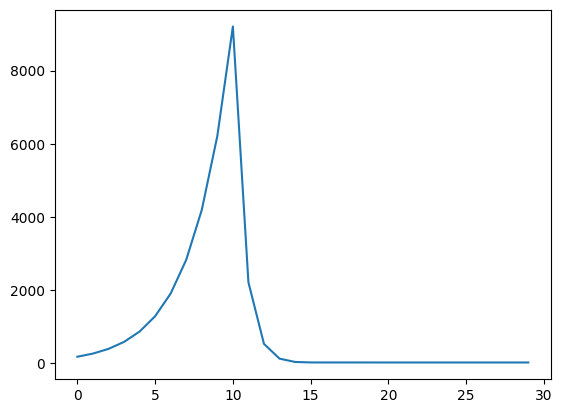

In [28]:
plt.plot(loss)
plt.show()

In [29]:
poly_features, X_train_pf, X_test_pf, y_train_pf, y_test_pf = poly_features(X, y)
poly_reg_y_predicted = model_poly_features(X_train_pf, X_test_pf, y_train_pf, y_test_pf)

Train Precision
rmse=0.9922355307637852
Mean squared error: 0.98
Coefficient of determination: 0.97
Score: 0.9660395163390302
Mean Absolute Error: 0.73591257304776
Test Precision
rmse=0.5788376939057532
intercept_=[6.3450478]
Coefficients: 
 [[ 0.          6.3187962   1.13412148  1.84021254 16.55198023 -2.83423663
  -0.31063849]]
Mean squared error: 0.34
Coefficient of determination: 0.98
Score: 0.9819613663776857
Mean Absolute Error: 0.49035421374158616


In [30]:
create_data_frame(y_test_pf, poly_reg_y_predicted)

    Actual Sales  Predicted Sales
0           23.8        23.569983
1           16.6        16.181460
2            9.5         8.614709
3           14.8        15.567029
4           17.6        18.136711
5           25.5        26.102272
6           16.9        16.379575
7           12.9        12.659322
8           10.5         9.847886
9           17.1        17.006630
10          14.5        14.244347
11          11.3        10.029372
12          17.4        17.251196
13          16.7        15.877207
14          13.4        13.243537
15          15.9        15.350499
16          12.9        12.426927
17          12.8        13.908023
18           9.5         8.972246
19          18.4        18.470072
20          10.7         9.799116
21          12.5        12.355161
22           8.5         8.708403
23          11.5        10.699082
24          11.9        11.564640
25          14.9        14.587859
26          10.1         9.526859
27          18.9        19.713453
28          19

Actual Sales  Predicted Sales
0           23.8        23.569983
1           16.6        16.181460
2            9.5         8.614709
3           14.8        15.567029
4           17.6        18.136711
5           25.5        26.102272
6           16.9        16.379575
7           12.9        12.659322
8           10.5         9.847886
9           17.1        17.006630
10          14.5        14.244347
11          11.3        10.029372
12          17.4        17.251196
13          16.7        15.877207
14          13.4        13.243537
15          15.9        15.350499
16          12.9        12.426927
17          12.8        13.908023
18           9.5         8.972246
19          18.4        18.470072
20          10.7         9.799116
21          12.5        12.355161
22           8.5         8.708403
23          11.5        10.699082
24          11.9        11.564640
25          14.9        14.587859
26          10.1         9.526859
27          18.9        19.713453
28          19.6        18.727263
29          15.9        16.243395
30          23.2        23.494169
31          11.9        12.002312
32          17.3        16.338735
33          11.7        11.688654
34          20.2        20.643564
35          15.5        15.115951
36          11.5        11.976502
37          11.0        10.209116
38          22.3        22.553171
39           7.6         7.862425

In [31]:
reg, ypred = reg_linear_sgd(X_train, X_test, y_train, y_test)

R-squared: 0.8959268462033323
CV mean score:  0.885717473378367
MSE:  2.01725719326798
RMSE:  1.420301796544657
intercept_=[13.80598702]
Coefficients: 
 [4.09530382 2.69467942 0.06395415]
Mean squared error: 2.02
Coefficient of determination: 0.89
Score: 0.8913946295371243
Mean Absolute Error: 1.0484074302350035


/usr/local/lib/python3.9/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example 

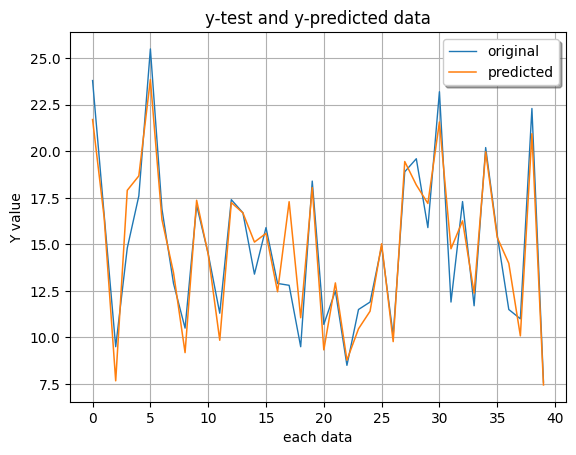

In [32]:
x_ax = range(len(y_test))
plt.plot(x_ax, y_test, linewidth=1, label="original")
plt.plot(x_ax, ypred, linewidth=1.1, label="predicted")
plt.title("y-test and y-predicted data")
plt.xlabel('each data')
plt.ylabel('Y value')
plt.legend(loc='best',fancybox=True, shadow=True)
plt.grid(True)
plt.show() 

In [33]:
reg, ypred = reg_linear_sgd_2(X_train, X_test, y_train, y_test)

R-squared: 0.8912672298586266
CV mean score:  0.8802398407265839
MSE:  2.2215309032318054
RMSE:  1.4904800915248098
intercept_=[3.52988822]
Coefficients: 
 [12.9274257   8.07171531  1.32660426]
Mean squared error: 2.22
Coefficient of determination: 0.88
Score: 0.880396913420169
Mean Absolute Error: 1.1215624947900584


/usr/local/lib/python3.9/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example 

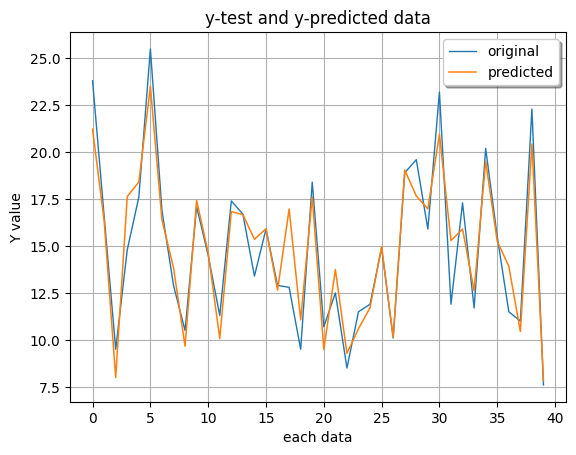

In [34]:
x_ax = range(len(y_test))
plt.plot(x_ax, y_test, linewidth=1, label="original")
plt.plot(x_ax, ypred, linewidth=1.1, label="predicted")
plt.title("y-test and y-predicted data")
plt.xlabel('each data')
plt.ylabel('Y value')
plt.legend(loc='best',fancybox=True, shadow=True)
plt.grid(True)
plt.show()

In [35]:
reg, ypred = reg_linear_sgd_3(X_train_pf, X_test_pf, y_train_pf, y_test_pf)

R-squared: 0.9635718059897914
CV mean score:  0.9547610283632798
MSE:  0.3996969488806383
RMSE:  0.632215903691641
intercept_=[13.81015473]
Coefficients: 
 [ 0.          1.99922283  0.74110945 -0.1655182   3.19065308  0.10859339
  0.10507573]
Mean squared error: 0.40
Coefficient of determination: 0.98
Score: 0.9784810606446571
Mean Absolute Error: 0.5287088017345666


/usr/local/lib/python3.9/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example 

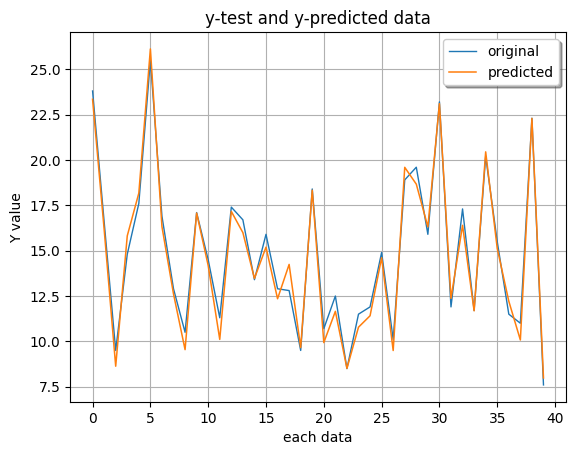

In [36]:
x_ax = range(len(y_test_pf))
plt.plot(x_ax, y_test_pf, linewidth=1, label="original")
plt.plot(x_ax, ypred, linewidth=1.1, label="predicted")
plt.title("y-test and y-predicted data")
plt.xlabel('each data')
plt.ylabel('Y value')
plt.legend(loc='best',fancybox=True, shadow=True)
plt.grid(True)
plt.show()

In [37]:
reg, ypred = reg_linear_sgd_4(X_train_pf, X_test_pf, y_train_pf, y_test_pf)

R-squared: 0.9478974122933643
CV mean score:  0.9394557971918708
MSE:  0.8690288785618747
RMSE:  0.9322171842236522
intercept_=[2.5844375]
Coefficients: 
 [ 2.57530407  8.84728623  4.59471511 -0.07168029  8.14691078  2.222109
  0.69475787]
Mean squared error: 0.87
Coefficient of determination: 0.95
Score: 0.9532131036071553
Mean Absolute Error: 0.7517961299110784


/usr/local/lib/python3.9/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example 

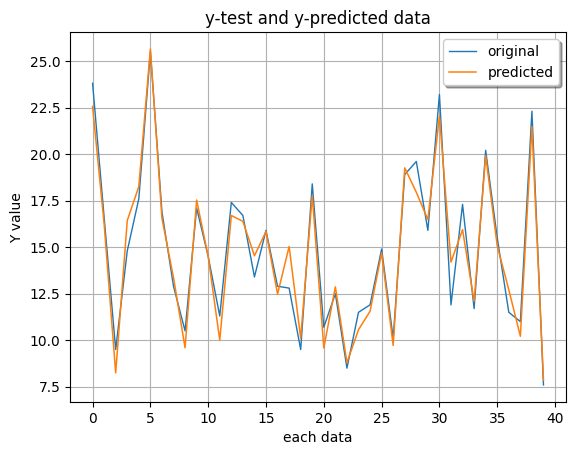

In [38]:
x_ax = range(len(y_test_pf))
plt.plot(x_ax, y_test_pf, linewidth=1, label="original")
plt.plot(x_ax, ypred, linewidth=1.1, label="predicted")
plt.title("y-test and y-predicted data")
plt.xlabel('each data')
plt.ylabel('Y value')
plt.legend(loc='best',fancybox=True, shadow=True)
plt.grid(True)
plt.show() 

In [39]:
sgdr, ypred = sgd_cv(X_train, X_test, y_train, y_test)

-- Epoch 1
Norm: 7.32, NNZs: 3, Bias: 7.905518, T: 160, Avg. loss: 26.510765
Total training time: 0.01 seconds.
-- Epoch 2
Norm: 8.49, NNZs: 3, Bias: 7.794613, T: 320, Avg. loss: 5.162835
Total training time: 0.01 seconds.
-- Epoch 3
Norm: 9.43, NNZs: 3, Bias: 7.541638, T: 480, Avg. loss: 4.330801
Total training time: 0.01 seconds.
-- Epoch 4
Norm: 10.05, NNZs: 3, Bias: 7.040793, T: 640, Avg. loss: 3.813623
Total training time: 0.01 seconds.
-- Epoch 5
Norm: 10.70, NNZs: 3, Bias: 6.667166, T: 800, Avg. loss: 3.398599
Total training time: 0.01 seconds.
-- Epoch 6
Norm: 11.16, NNZs: 3, Bias: 6.158714, T: 960, Avg. loss: 3.046202
Total training time: 0.01 seconds.
-- Epoch 7
Norm: 11.73, NNZs: 3, Bias: 5.903269, T: 1120, Avg. loss: 2.768498
Total training time: 0.02 seconds.
-- Epoch 8
Norm: 12.24, NNZs: 3, Bias: 5.686018, T: 1280, Avg. loss: 2.525853
Total training time: 0.02 seconds.
-- Epoch 9
Norm: 12.63, NNZs: 3, Bias: 5.385996, T: 1440, Avg. loss: 2.357090
Total training time: 0.02 

/usr/local/lib/python3.9/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


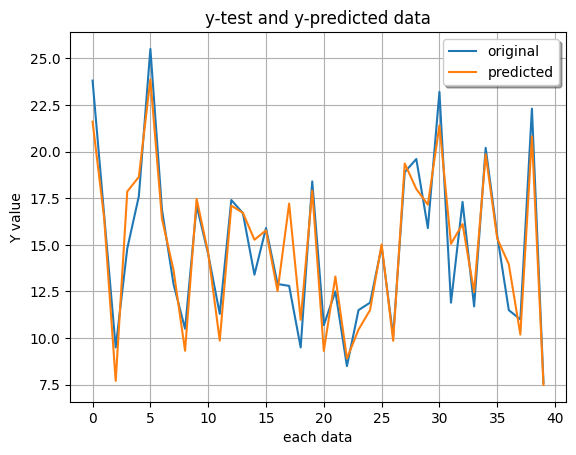

In [40]:
x_ax = range(len(y_test))
plt.plot(x_ax, y_test, label="original")
plt.plot(x_ax, ypred, label="predicted")
plt.title("y-test and y-predicted data")
plt.xlabel('each data')
plt.ylabel('Y value')
plt.legend(loc='best',fancybox=True, shadow=True)
plt.grid(True)
plt.show()

In [41]:
sgdr, ypred = sgd_cv(X_train_pf, X_test_pf, y_train_pf, y_test_pf)

-- Epoch 1
Norm: 7.52, NNZs: 7, Bias: 4.613101, T: 160, Avg. loss: 19.142674
Total training time: 0.00 seconds.
-- Epoch 2
Norm: 8.51, NNZs: 7, Bias: 4.369983, T: 320, Avg. loss: 4.555941
Total training time: 0.00 seconds.
-- Epoch 3
Norm: 9.13, NNZs: 7, Bias: 3.936869, T: 480, Avg. loss: 3.429526
Total training time: 0.01 seconds.
-- Epoch 4
Norm: 9.81, NNZs: 7, Bias: 3.675065, T: 640, Avg. loss: 2.634713
Total training time: 0.01 seconds.
-- Epoch 5
Norm: 10.36, NNZs: 7, Bias: 3.429760, T: 800, Avg. loss: 2.101132
Total training time: 0.01 seconds.
-- Epoch 6
Norm: 10.95, NNZs: 7, Bias: 3.335712, T: 960, Avg. loss: 1.714607
Total training time: 0.01 seconds.
-- Epoch 7
Norm: 11.37, NNZs: 7, Bias: 3.182600, T: 1120, Avg. loss: 1.452197
Total training time: 0.01 seconds.
-- Epoch 8
Norm: 11.64, NNZs: 7, Bias: 2.971321, T: 1280, Avg. loss: 1.286990
Total training time: 0.01 seconds.
-- Epoch 9
Norm: 11.92, NNZs: 7, Bias: 2.840941, T: 1440, Avg. loss: 1.145241
Total training time: 0.01 s

/usr/local/lib/python3.9/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


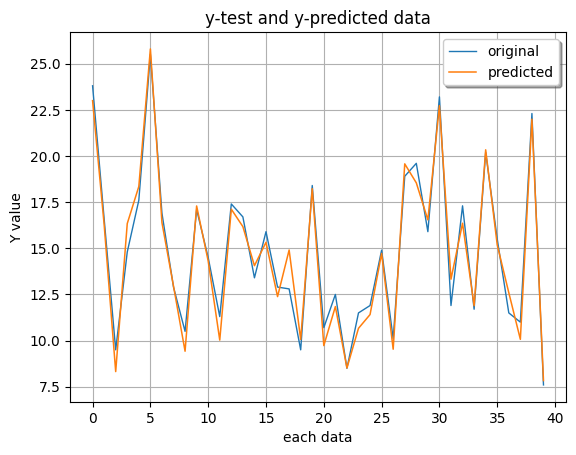

In [42]:
x_ax = range(len(y_test_pf))
plt.plot(x_ax, y_test_pf, linewidth=1, label="original")
plt.plot(x_ax, ypred, linewidth=1.1, label="predicted")
plt.title("y-test and y-predicted data")
plt.xlabel('each data')
plt.ylabel('Y value')
plt.legend(loc='best',fancybox=True, shadow=True)
plt.grid(True)
plt.show()

In [43]:
gs_linear_model, ypred = sgd_cv_1(X_train, X_test, y_train, y_test)

-- Epoch 1
Norm: 1.01, NNZs: 3, Bias: 1.590000, T: 160, Avg. loss: 12.603728
Total training time: 0.00 seconds.
-- Epoch 2
Norm: 2.00, NNZs: 3, Bias: 3.170000, T: 320, Avg. loss: 10.413579
Total training time: 0.01 seconds.
-- Epoch 3
Norm: 3.00, NNZs: 3, Bias: 4.720000, T: 480, Avg. loss: 8.255178
Total training time: 0.01 seconds.
-- Epoch 4
Norm: 3.92, NNZs: 3, Bias: 6.070000, T: 640, Avg. loss: 6.342684
Total training time: 0.01 seconds.
-- Epoch 5
Norm: 4.76, NNZs: 3, Bias: 7.260000, T: 800, Avg. loss: 4.854711
Total training time: 0.01 seconds.
-- Epoch 6
Norm: 5.53, NNZs: 3, Bias: 8.220000, T: 960, Avg. loss: 3.720285
Total training time: 0.01 seconds.
-- Epoch 7
Norm: 6.08, NNZs: 3, Bias: 8.650000, T: 1120, Avg. loss: 3.166105
Total training time: 0.01 seconds.
-- Epoch 8
Norm: 6.50, NNZs: 3, Bias: 8.850000, T: 1280, Avg. loss: 2.972738
Total training time: 0.01 seconds.
-- Epoch 9
Norm: 6.85, NNZs: 3, Bias: 8.920000, T: 1440, Avg. loss: 2.897609
Total training time: 0.01 secon

/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
780 fits failed out of a total of 1350.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
45 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_stochastic_gradient.py", line 1582, in fit
    self._validate_params()
  File "/usr/local/lib/python3.9/dist-packages/sklearn/base.py", line 600, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.9/dist-packag

In [44]:
print("Best score: " + str(gs_linear_model.best_score_))
print(f"best estimator is {gs_linear_model.best_estimator_}")
print(f"best parameters are {gs_linear_model.best_params_}")
print(f"best coefficients are {gs_linear_model.best_estimator_.coef_}")
print(f"best intercept_ is {gs_linear_model.best_estimator_.intercept_}")

ypred = gs_linear_model.predict(X_train)
print("train Precision")
print("Mean squared error: %.2f" % mean_squared_error(y_train, ypred))
print("Coefficient of determination: %.2f" % r2_score(y_train, ypred))
print('Score:', gs_linear_model.score(X_train, y_train))
print('Mean Absolute Error:', metrics.mean_absolute_error(y_train, ypred))


ypred = gs_linear_model.predict(X_test)
print("Test Precision")
print("Mean squared error: %.2f" % mean_squared_error(y_test, ypred))
print("Coefficient of determination: %.2f" % r2_score(y_test, ypred))
print('Score:', gs_linear_model.score(X_test, y_test))
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, ypred))

Best score: 0.8073672102150329
best estimator is SGDRegressor(alpha=0.09999999999999964, learning_rate='adaptive',
             loss='epsilon_insensitive', max_iter=100, penalty='l1',
             verbose=10)
best parameters are {'alpha': 0.09999999999999964, 'loss': 'epsilon_insensitive', 'penalty': 'l1'}
best coefficients are [10.05885695  6.68264113  0.        ]
best intercept_ is [5.99]
train Precision
Mean squared error: 4.89
Coefficient of determination: 0.83
Score: 0.8313076748531023
Mean Absolute Error: 1.603641471326111
Test Precision
Mean squared error: 2.99
Coefficient of determination: 0.84
Score: 0.8389735784937316
Mean Absolute Error: 1.2621174900775558


In [45]:
create_data_frame(y_test, ypred)

    Actual Sales  Predicted Sales
0           23.8        19.819634
1           16.6        15.859145
2            9.5         9.410248
3           14.8        16.858560
4           17.6        17.469492
5           25.5        21.272126
6           16.9        15.778670
7           12.9        13.571571
8           10.5        10.523486
9           17.1        16.473115
10          14.5        14.377872
11          11.3        11.082150
12          17.4        16.503196
13          16.7        16.141392
14          13.4        14.752041
15          15.9        15.213699
16          12.9        12.925285
17          12.8        16.407355
18           9.5        12.091522
19          18.4        17.108146
20          10.7        10.674919
21          12.5        13.203690
22           8.5        10.282595
23          11.5        11.505854
24          11.9        12.151032
25          14.9        14.813635
26          10.1        11.029634
27          18.9        18.080844
28          19

Actual Sales  Predicted Sales
0           23.8        19.819634
1           16.6        15.859145
2            9.5         9.410248
3           14.8        16.858560
4           17.6        17.469492
5           25.5        21.272126
6           16.9        15.778670
7           12.9        13.571571
8           10.5        10.523486
9           17.1        16.473115
10          14.5        14.377872
11          11.3        11.082150
12          17.4        16.503196
13          16.7        16.141392
14          13.4        14.752041
15          15.9        15.213699
16          12.9        12.925285
17          12.8        16.407355
18           9.5        12.091522
19          18.4        17.108146
20          10.7        10.674919
21          12.5        13.203690
22           8.5        10.282595
23          11.5        11.505854
24          11.9        12.151032
25          14.9        14.813635
26          10.1        11.029634
27          18.9        18.080844
28          19.6        17.298929
29          15.9        16.383696
30          23.2        19.718213
31          11.9        14.401283
32          17.3        15.854960
33          11.7        12.806798
34          20.2        18.484902
35          15.5        15.085294
36          11.5        13.989676
37          11.0        11.135966
38          22.3        19.255772
39           7.6         9.341010

In [46]:
gs_linear_model, ypred = sgd_cv_1(X_train_pf, X_test_pf, y_train_pf, y_test_pf)

-- Epoch 1
Norm: 1.85, NNZs: 7, Bias: 1.600000, T: 160, Avg. loss: 11.853339
Total training time: 0.01 seconds.
-- Epoch 2
Norm: 3.55, NNZs: 7, Bias: 3.040000, T: 320, Avg. loss: 8.295555
Total training time: 0.01 seconds.
-- Epoch 3
Norm: 5.02, NNZs: 7, Bias: 4.260000, T: 480, Avg. loss: 5.550138
Total training time: 0.01 seconds.
-- Epoch 4
Norm: 5.98, NNZs: 7, Bias: 4.960000, T: 640, Avg. loss: 3.915808
Total training time: 0.01 seconds.
-- Epoch 5
Norm: 6.58, NNZs: 7, Bias: 5.310000, T: 800, Avg. loss: 3.393310
Total training time: 0.01 seconds.
-- Epoch 6
Norm: 6.95, NNZs: 7, Bias: 5.430000, T: 960, Avg. loss: 3.212306
Total training time: 0.01 seconds.
-- Epoch 7
Norm: 7.26, NNZs: 6, Bias: 5.500000, T: 1120, Avg. loss: 3.141564
Total training time: 0.01 seconds.
-- Epoch 8
Norm: 7.56, NNZs: 6, Bias: 5.540000, T: 1280, Avg. loss: 3.065253
Total training time: 0.01 seconds.
-- Epoch 9
Norm: 7.88, NNZs: 5, Bias: 5.620000, T: 1440, Avg. loss: 3.010275
Total training time: 0.01 second

/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
780 fits failed out of a total of 1350.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
45 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_stochastic_gradient.py", line 1582, in fit
    self._validate_params()
  File "/usr/local/lib/python3.9/dist-packages/sklearn/base.py", line 600, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.9/dist-packag

In [47]:
print("Best score: " + str(gs_linear_model.best_score_))
print(f"best estimator is {gs_linear_model.best_estimator_}")
print(f"best parameters are {gs_linear_model.best_params_}")
print(f"best coefficients are {gs_linear_model.best_estimator_.coef_}")
print(f"best intercept_ is {gs_linear_model.best_estimator_.intercept_}")


ypred = gs_linear_model.predict(X_train_pf)
print("train Precision")
print("Mean squared error: %.2f" % mean_squared_error(y_train_pf, ypred))
print("Coefficient of determination: %.2f" % r2_score(y_train_pf, ypred))
print('Score:', gs_linear_model.score(X_train_pf, y_train_pf))
print('Mean Absolute Error:', metrics.mean_absolute_error(y_train_pf, ypred))


ypred = gs_linear_model.predict(X_test_pf)

print("Mean squared error: %.2f" % mean_squared_error(y_test_pf, ypred))
print("Coefficient of determination: %.2f" % r2_score(y_test_pf, ypred))
print('Score:', gs_linear_model.score(X_test_pf, y_test_pf))
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test_pf, ypred))

Best score: 0.9227815879833425
best estimator is SGDRegressor(alpha=0.09999999999999964, learning_rate='adaptive',
             loss='epsilon_insensitive', max_iter=100, penalty='l1',
             verbose=10)
best parameters are {'alpha': 0.09999999999999964, 'loss': 'epsilon_insensitive', 'penalty': 'l1'}
best coefficients are [0.         7.47952317 4.24693548 0.         8.60016791 0.
 0.        ]
best intercept_ is [6.46]
train Precision
Mean squared error: 1.89
Coefficient of determination: 0.93
Score: 0.934638975769161
Mean Absolute Error: 0.9145313035467021
Mean squared error: 0.69
Coefficient of determination: 0.96
Score: 0.9629605774935994
Mean Absolute Error: 0.6559180599554004


In [48]:
create_data_frame(y_test_pf, ypred)

    Actual Sales  Predicted Sales
0           23.8        22.131836
1           16.6        16.112558
2            9.5         9.060819
3           14.8        16.049856
4           17.6        17.846925
5           25.5        24.179118
6           16.9        16.291439
7           12.9        13.080781
8           10.5        10.253850
9           17.1        16.882509
10          14.5        14.400142
11          11.3        10.771359
12          17.4        16.939559
13          16.7        16.370344
14          13.4        13.938199
15          15.9        15.485947
16          12.9        12.762422
17          12.8        14.843600
18           9.5        10.998579
19          18.4        17.930282
20          10.7        10.365058
21          12.5        12.731124
22           8.5         9.645413
23          11.5        11.233557
24          11.9        11.932637
25          14.9        14.749654
26          10.1        10.482452
27          18.9        18.998401
28          19

Actual Sales  Predicted Sales
0           23.8        22.131836
1           16.6        16.112558
2            9.5         9.060819
3           14.8        16.049856
4           17.6        17.846925
5           25.5        24.179118
6           16.9        16.291439
7           12.9        13.080781
8           10.5        10.253850
9           17.1        16.882509
10          14.5        14.400142
11          11.3        10.771359
12          17.4        16.939559
13          16.7        16.370344
14          13.4        13.938199
15          15.9        15.485947
16          12.9        12.762422
17          12.8        14.843600
18           9.5        10.998579
19          18.4        17.930282
20          10.7        10.365058
21          12.5        12.731124
22           8.5         9.645413
23          11.5        11.233557
24          11.9        11.932637
25          14.9        14.749654
26          10.1        10.482452
27          18.9        18.998401
28          19.6        18.348233
29          15.9        16.289677
30          23.2        21.884586
31          11.9        13.131046
32          17.3        16.387410
33          11.7        12.190492
34          20.2        19.697619
35          15.5        15.185515
36          11.5        12.800862
37          11.0        10.633588
38          22.3        21.247775
39           7.6         8.881856